In [32]:
import wandb
import pandas as pd
import seml
import numpy as np
import matplotlib.pyplot as plt
import jax

In [2]:
api = wandb.Api()

In [ ]:
array_id = seml.get_results("sparse_n2_check", fields=["execution.array_id"], states=[], progress=False)[0][
    "execution"
]["array_id"]

In [33]:
pp_runs = list(
    api.runs(
        "tum_daml_nicholas/ngao_n2",
        filters={
            "config.logging_args.collection": "sparse_n2_check",
            "config.logging_args.name": {"$contains": str(array_id)},
            "config.molecule_args.pseudopotentials": {"$size": 1},
        },
    )
)
runs = list(
    api.runs(
        "tum_daml_nicholas/ngao_n2",
        filters={
            "config.logging_args.collection": "sparse_n2_check",
            "config.logging_args.name": {"$contains": str(array_id)},
            "config.molecule_args.pseudopotentials": {"$size": 0},
        },
    )
)

In [34]:
runs = jax.tree_map(lambda r: pd.DataFrame(r.scan_history(keys=['opt/E_smooth'])), runs)
pp_runs = jax.tree_map(lambda r: pd.DataFrame(r.scan_history(keys=['opt/E_smooth'])), pp_runs)

In [96]:
gs = np.argmin([r.min().to_numpy().astype(float) for r in runs])
gs_pp = np.nanargmin([r.min().to_numpy().astype(float) for r in pp_runs])

(-109.6, -109.0)

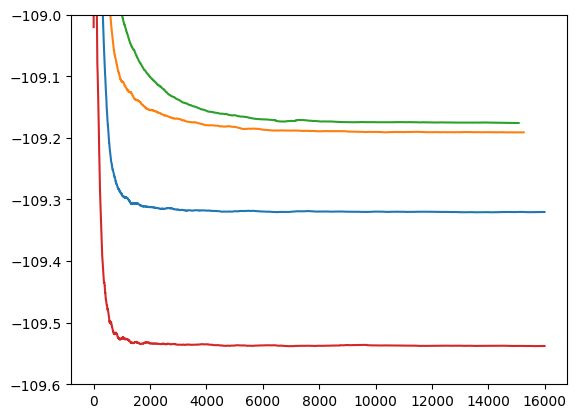

In [97]:
for r in runs:
    plt.plot(r)
plt.ylim(-109.6, -109)

[0.         0.21191152 0.3391331  0.35881283]


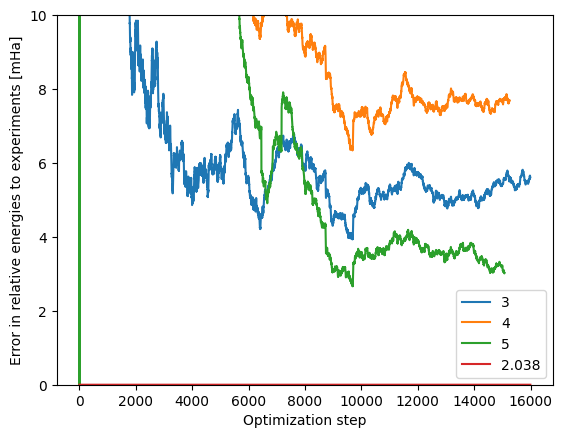

In [98]:
distances = [2.038, 3, 4, 5]
targets = np.array(N2(distances)) - np.array(N2([distances[0]]))
print(targets)
for r in runs:
    delta = (r - runs[gs]).to_numpy().astype(float)
    delta = delta[~np.isnan(delta)]
    target = np.argmin(np.abs(targets - delta[-1]))
    plt.plot((delta - targets[target]) * 1000, label=distances[target])
plt.ylim(0, 10)
# for x in np.array(N2([3, 4, 5])) - np.array(N2([2.038])):
#     plt.axhline(x, color='black', linestyle='--')
plt.ylabel("Error in relative energies to experiments [mHa]")
plt.xlabel("Optimization step")
plt.legend()
plt.show()

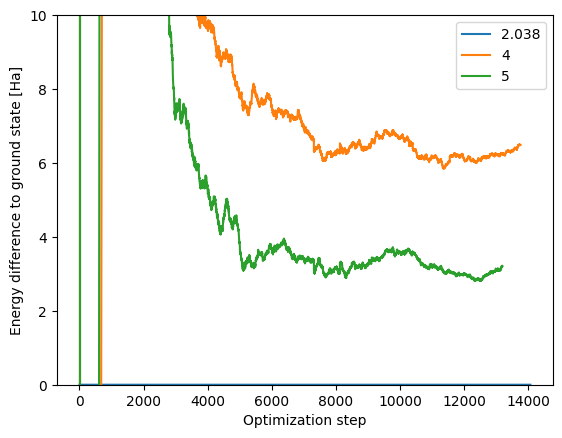

In [100]:
distances = [2.038, 3, 4, 5]
targets = np.array(N2(distances)) - np.array(N2([distances[0]]))
for r in pp_runs:
    try:
        delta = (r - pp_runs[gs_pp]).to_numpy().astype(float)
    except:
        continue
    delta = delta[~np.isnan(delta)]
    target = np.argmin(np.abs(targets - delta[-1]))
    plt.plot((delta - targets[target]) * 1000, label=distances[target])
plt.ylim(0, 10)
# for x in np.array(N2([3, 4, 5])) - np.array(N2([2.038])):
#     plt.axhline(x, color='black', linestyle='--')
plt.ylabel("Energy difference to ground state [Ha]")
plt.xlabel("Optimization step")
plt.legend()
plt.show()

In [55]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import os.path as osp
import json
import pickle
import seml
import yaml

BOHR_TO_ANGSTROM = 0.52917721067
ANGSTROM_TO_BOHR = 1.0 / BOHR_TO_ANGSTROM

HARTREE_TO_EV = 27.211386024367243
EV_TO_KCAL = 23.060548012069493
EV_TO_HARTREE = 1.0 / HARTREE_TO_EV
KCAL_TO_EV = 1.0 / EV_TO_KCAL
HARTREE_TO_KCAL = HARTREE_TO_EV * EV_TO_KCAL
KCAL_TO_HARTREE = 1.0 / HARTREE_TO_KCAL

HARTREE_TO_INV_CM = 219474.63
INV_CM_TO_HARTREE = 1.0 / HARTREE_TO_INV_CM


N_ENERGY = -54.5892


def h4_rect(method):
    data = pd.read_csv(extend_path("data/ferminet/h4.csv"))
    result = np.array(
        [
            data[data["method"] == method]["angle"].to_numpy(),
            data[data["method"] == method]["energy"].to_numpy(),
        ]
    ).T
    return result


def cyclobutadiene(state, method, alpha=None):
    method = method.lower()
    if method == "paulinet":
        result = pd.read_csv(extend_path("data/cyclobutdiene_paulinet.csv"))
        result = result[result["state"] == state]
        result = result[result["batch"] == 250]
        result = result.rename(columns={"energy_ewm": "energy"})
        alpha = None
    elif method == "pesnet":
        result = pd.read_csv(extend_path("data/cyclobutadiene_pesnet.csv"))
        result = result[result["state"] == state]
    elif method in ("pesnetpp", "pesnet++"):
        result = pd.read_csv(extend_path("data/cyclobutadiene_pesnetpp.csv"))
        result = result[result["state"] == state]
    elif method == "ferminet":
        new_name = {
            "ground": "cycbut-ground",
            "transition": "cycbut-trans",
        }[state]
        result = pd.read_csv(extend_path("data/ferminet/cyclobutadiene.csv"))
        result = result[result["system"] == new_name]
    if alpha is not None:
        result["energy"] = result["energy"].ewm(alpha=alpha).mean()
    return result[["step", "energy"]]


def N2(r):
    D_e = 79845
    C_n = 1.16e5
    R_m_n = 5.5
    r_e = 1.097679
    phi = np.array(
        [-2.34414547, -0.972465, -1.561777, -1.136, -1.3963, -0.819, -0.45, -3.36, 2.1]
    )
    p = 4
    m = 8
    n = 6
    phi_inf = np.log((2 * D_e * (r_e**n)) / (C_n * (1 + R_m_n / (r_e ** (m - n)))))

    def phi_of(r):
        y = np.array(y_p(r))
        if r > r_e:
            y_i = np.array([y**i for i in range(m + 1)])
            return (1 - y) * (phi * y_i).sum() + y * phi_inf
        else:
            y_i = np.array([y**i for i in range(n + 1)])
            return (1 - y) * (phi[: n + 1] * y_i).sum() + y * phi_inf

    def y_p(r):
        return (r**p - r_e**p) / (r**p + r_e**p)

    def V(r):
        return (
            D_e
            * (
                1
                - (r_e / r) ** n
                * ((1 + R_m_n / (r ** (m - n))) / (1 + R_m_n / (r_e ** (m - n))))
                * np.exp(-phi_of(r) * y_p(r))
            )
            ** 2
        )

    r = np.array(r)
    return [
        (V(r_ * 0.52917721067) - D_e) * INV_CM_TO_HARTREE + 2 * N_ENERGY for r_ in r
    ]


def extend_path(path):
    return osp.join(osp.dirname(__file__), path)


def N2_references(method):
    data = pd.read_csv(extend_path("data/ferminet/n2.csv"))
    if method in set(data["method"].unique()):
        result = np.array(
            [
                data[data["method"] == method]["bond_length"].to_numpy(),
                data[data["method"] == method]["energy"].to_numpy(),
            ]
        ).T
        return result
    elif method == "Gold-Standard":
        result = np.array(
            [
                1.5982996811902233,
                0.20202020202020066,
                2.066950053134963,
                0.8529741863075202,
                2.133900106269926,
                0.9203142536475859,
                2.6663124335812967,
                1.212121212121211,
                3.201912858660999,
                2.1324354657688005,
                3.7375132837407015,
                3.4792368125701465,
                3.9989373007438895,
                3.299663299663301,
                4.269925611052072,
                2.8058361391694753,
                4.805526036131775,
                2.1099887766554453,
                5.341126461211477,
                1.0549943883277209,
            ]
        ).reshape(-1, 2)
        result[:, 1] = result[:, 1] / 1000 + N2(result[:, 0])
        return result
    elif method == "DMC":
        result = np.array(
            [
                1.6016,
                0.03384094754652622,
                1.7024,
                0.5752961082910311,
                1.7983999999999998,
                0.6429780033840906,
                1.8991999999999998,
                0.6091370558375608,
                2,
                0.6673678754897061,
                2.2,
                0.5914543985610017,
                2.4000000000000004,
                0.6926723677992754,
                2.6000000000000005,
                0.9077605524306058,
                2.8000000000000007,
                1.0722397524428011,
                3.000000000000001,
                1.3758936601576224,
                3.2000000000000006,
                1.5656773524793834,
                3.4000000000000012,
                2.248898644837734,
                3.600000000000001,
                2.8435542141125936,
                3.8000000000000016,
                3.1598603679821977,
                4.200000000000002,
                3.1345558756726284,
                4.400000000000002,
                2.8688587064221593,
                4.600000000000002,
                2.792945229493455,
                4.8000000000000025,
                3.1725126141369806,
                5.000000000000003,
                2.4133778448499292,
                5.200000000000003,
                2.021158214051617,
                5.400000000000003,
                1.6542430755628743,
            ]
        ).reshape(-1, 2)
        result[:, 1] = result[:, 1] / 1000 + N2(result[:, 0])
        return result
    elif method == "PESNet":
        data = np.loadtxt(extend_path("data/n2_pesnet.csv"), delimiter="|", skiprows=1)
        return data[:, :2]
    else:
        raise NotImplementedError()


def LiH(r):
    a_1 = 1.22557220
    a_2 = 0.39520923
    a_3 = 0.08900218
    D_e = 2.520 * EV_TO_HARTREE
    R_e = 3.01543683

    p = r - R_e
    return (
        -D_e * (1 + a_1 * p + a_2 * p**2 + a_3 * p**3) * np.exp(-a_1 * p)
        - 7.47806032
        - 0.5
    )


def Li2(r, method="rkr"):
    def rkr(r):
        a_1 = 1.05010756
        a_2 = 0.34091634
        a_3 = 0.04658989
        D_e = 1.060 * EV_TO_HARTREE
        R_e = 5.05176690

        p = r - R_e
        return (
            -D_e * (1 + a_1 * p + a_2 * p**2 + a_3 * p**3) * np.exp(-a_1 * p)
            + 2 * -7.47806032
        )

    def fcipp(r):
        a_1 = 0.99833789
        a_2 = 0.28789267
        a_3 = 0.03292825
        D_e = 1.060 * EV_TO_HARTREE
        R_e = 5.05176690

        p = r - R_e
        return (
            -D_e * (1 + a_1 * p + a_2 * p**2 + a_3 * p**3) * np.exp(-a_1 * p)
            + 2 * -7.47806032
        )

    if method == "rkr":
        return rkr(r)
    elif method == "fcipp":
        return fcipp(r)
    else:
        raise NotImplementedError()


def Li2_baseline(method):
    if method == "mcci":
        # https://aip.scitation.org/doi/pdf/10.1063/1.441645?casa_token=T64CqhR2gNYAAAAA:gY2-9YNH7P5QNJ75rz37gE23i5PzfZtWZnrzdLr-eI8-zi1-VRE3JhmAwAfG323_4j-CAeQGnLR_og
        data = np.array(
            [
                [3.50, -0.92967],
                [4.00, -0.95153],
                [4.60, -0.96316],
                [4.80, -0.96460],
                [4.90, -0.96499],
                [5.00, -0.96517],
                [5.05, -0.96519],
                [5.10, -0.96518],
                [5.15, -0.89769],
                [5.25, -0.96491],
                [5.55, -0.96353],
                [6.20, -0.95815],
                [7.70, -0.94341],
                [10.00, -0.93157],
                [100.00, -0.92840],
            ]
        )
        data[:, 1] += 14
        return data


def H6():
    with open(extend_path("data/deeperwin/pretrain_H6.yml"), "r") as inp:
        data = yaml.safe_load(inp)["changes"]
    return [[x["comment"], x["E_ref"]] for x in data]


def deeperwin_ref(mol, opt="finetuning"):
    with open(extend_path(f"data/deeperwin/{opt}_{mol}.yml"), "r") as inp:
        data = yaml.safe_load(inp)["changes"]
    return [[x["comment"], x["E_ref"]] for x in data]


def deeperwin_fig3(mol, opt):
    data = pd.read_csv(extend_path("data/deeperwin/Fig3_weight_reuse.csv"))
    data = data[data["molecule"] == mol]
    options = {
        "direct": "Independent opt. (blue)",
        "same": "Pre-trained by shared opt. (violet)",
        "smaller": "Pre-trained by shared opt. of smaller molecule (red)",
    }
    if opt not in options:
        raise ValueError(f"{opt} not in {options.keys()}")
    opt = options[opt]
    data = data[data["Curve (color in plot)"] == opt]
    steps = data.to_numpy()[:, 3:4].astype(int)
    errors = data.to_numpy()[:, 4:].astype(float)
    mask = ~np.isnan(errors[0])
    errors = errors[:, mask]
    return np.concatenate([steps, errors], axis=1)


def H10(x):
    def find_val(x):
        data = H10_references("mrci_q_f12")
        xs = data[:, 0]
        ys = data[:, 1]
        if x in xs:
            return ys[list(xs).index(x)]
        else:
            raise ValueError()

    return np.array([find_val(x_) for x_ in x])


def H10_references(method):
    if method == "mrci_q_f12":
        result = np.array(
            [
                [1.0, -0.44301],
                [1.2, -0.51506],
                [1.4, -0.54917],
                [1.6, -0.56321],
                [1.8, -0.56654],
                [2.0, -0.56410],
                [2.4, -0.55187],
                [2.8, -0.53753],
                [3.2, -0.52500],
                [3.6, -0.51553],
            ]
        )
        result[:, 1] *= 10
        return result
    elif method == "mrci_q_f12_err":
        result = np.array(
            [
                [1.0, 0.0031],
                [1.2, 0.0012],
                [1.4, 0.0012],
                [1.6, 0.0007],
                [1.8, 0.0005],
                [2.0, 0.0003],
                [2.4, 0.0001],
                [2.8, 0.0003],
                [3.2, 0.0005],
                [3.6, 0.0005],
            ]
        )
        result[:, 1] *= 10
        return result
    elif method == "afqmc":
        result = np.array(
            [
                [1.0, -0.44284],
                [1.2, -0.51489],
                [1.4, -0.54914],
                [1.6, -0.56315],
                [1.8, -0.56644],
                [2.0, -0.56396],
                [2.4, -0.55164],
                [2.8, -0.53755],
                [3.2, -0.52499],
                [3.6, -0.51568],
            ]
        )
        result[:, 1] *= 10
        return result
    elif method == "uccsd":
        uccsd = np.array(
            [
                [1.0, -0.44207],
                [1.2, -0.51432],
                [1.4, -0.54846],
                [1.6, -0.56240],
                [1.8, -0.56533],
                [2.0, -0.56239],
                [2.4, -0.54953],
                [2.8, -0.53519],
                [3.2, -0.52303],
                [3.6, -0.51407],
            ]
        )
        uccsd[:, 1] *= 10
        return uccsd
    elif method == "uccsd_t":
        uccsd_t = np.array(
            [
                [1.0, -0.44268],
                [1.2, -0.51490],
                [1.4, -0.54907],
                [1.6, -0.56311],
                [1.8, -0.56623],
                [2.0, -0.56341],
                [2.4, -0.55037],
                [2.8, -0.53577],
                [3.2, -0.52340],
                [3.6, -0.51428],
            ]
        )
        uccsd_t[:, 1] *= 10
        return uccsd_t
    elif method == "vmc_agp":
        vmc_agp = np.array(
            [
                [1.0, -0.441499],
                [1.2, -0.513646],
                [1.4, -0.548046],
                [1.6, -0.562237],
                [1.8, -0.565634],
                [2.0, -0.563249],
                [2.4, -0.551106],
                [2.8, -0.536832],
                [3.2, -0.524373],
                [3.6, -0.514968],
            ]
        )
        vmc_agp[:, 1] *= 10
        return vmc_agp
    elif method == "paulinet":
        paulinet = np.array(
            [
                [1.2, -5.1435980796813965],
                [1.4, -5.486588954925537],
                [1.6, -5.6281046867370605],
                [1.8, -5.661114692687988],
                [2.0, -5.636511325836182],
                [2.4, -5.5140910148620605],
                [2.8, -5.370560646057129],
                [3.2, -5.244682788848877],
                [3.6, -5.148167133331299],
            ]
        )
        return paulinet
    elif method == "ferminet":
        data = pd.read_csv(extend_path("data/ferminet/h10.csv"))
        ferminet = np.array(
            [
                data[data["method"] == "FermiNet"]["bond_length"].to_numpy(),
                data[data["method"] == "FermiNet"]["energy"].to_numpy(),
            ]
        ).T
        return ferminet
    elif method == "deeperwin":
        with open(extend_path("data/deeperwin_h10.pkl"), "rb") as f:
            deeperwin = pickle.load(f)

        def get_de(epochs, reuse):
            de_h10 = deeperwin[deeperwin["name"] == "HChain10"]
            de_h10 = de_h10[de_h10["n_epochs"] == epochs]
            if reuse:
                de_h10 = de_h10[de_h10["reuse_source"] == "HChain10"]
            else:
                de_h10 = de_h10[de_h10["method"] == f"independent_{epochs}ep"]
            de_h10 = de_h10.sort_values(by="geom")
            de_h10 = de_h10["E_eval"].to_numpy()
            r = np.array([1.2, 1.4, 1.6, 1.8, 2.0, 2.4, 2.8, 3.2, 3.6])
            deep_erwin = np.stack([r, de_h10]).T
            return deep_erwin

        return get_de(8192, False)
    elif method == "deeperwin_warm":
        with open(extend_path("data/deeperwin_h10.pkl"), "rb") as f:
            deeperwin = pickle.load(f)

        def get_de(epochs, reuse):
            de_h10 = deeperwin[deeperwin["name"] == "HChain10"]
            de_h10 = de_h10[de_h10["n_epochs"] == epochs]
            if reuse:
                de_h10 = de_h10[de_h10["reuse_source"] == "HChain10"]
            else:
                de_h10 = de_h10[de_h10["method"] == f"independent_{epochs}ep"]
            de_h10 = de_h10.sort_values(by="geom")
            de_h10 = de_h10["E_eval"].to_numpy()
            r = np.array([1.2, 1.4, 1.6, 1.8, 2.0, 2.4, 2.8, 3.2, 3.6])
            deep_erwin = np.stack([r, de_h10]).T
            return deep_erwin

        return get_de(8192, True)
    elif method == "PESNet":
        data = seml.get_results(
            "wf_base", filter_dict={"config.system.name": "h_chain"}
        )[0]
        r = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.4, 2.8, 3.2, 3.6])
        E = data["result"]["E_final"]
        return np.array([r, E]).T


def ethanol_2d(theta, phi):
    def _ethanol(angles):
        theta, phi = angles
        theta, phi = np.radians(theta), np.radians(phi)
        V_nOH = np.array([86.3, -4.37, 381.9, -32.7])
        V_CH30 = 1208.4
        V_nx = np.array([0.0653, 0.000147, 0.00827])

        def V_OH(phi):
            return 0.5 * np.vdot(V_nOH, 1 - np.cos(np.arange(1, 5) * phi))

        def V_CH3(theta):
            return V_CH30 * 0.5 * (1 - np.cos(3 * theta))

        def correction(phi):
            return 1 + np.vdot(V_nx, 1 - np.cos(np.arange(1, 4) * phi))

        return V_CH3(correction(phi)) * (0.5) * (1 - np.cos(3 * theta)) + V_OH(phi)

    return np.array(list(map(_ethanol, zip(theta, phi))))


def ethanol(state):
    src_file = os.path.join(Path(__file__).parent, "data", "ethanol", f"{state}.csv")
    return np.genfromtxt(src_file, delimiter=",")


def h2hf_2d():
    src_file = os.path.join(Path(__file__).parent, "data", "h2hf_2d.csv")
    return pd.read_csv(src_file)
